## Check RTS-96 results with new code

This is what happens when I use `eigs`:

```julia
   2.483 seconds      (28280 allocations: 2971 KB)
sort(score)
11.6044
11.6044
99.7364
100.06  
100.27  
100.451 
101.157 
101.681 
102.128 
102.437 
102.535 
102.872 
103.489 
  ⋮     
 ```
 These numbers are clearly wrong. I switched back to `eig` and got this:
 
 ```julia
    3.804 seconds      (28338 allocations: 2846 KB)
sort(score) 
0.263788
0.327322
1.2886  
2.20415 
2.32297 
2.42316 
4.67867 
4.86524 
4.89916 
5.67824 
5.93851 
6.43917 
6.46089 
  ⋮  
```
These numbers are more reasonable, and the lowest score corresponds to line `(14,16)` as before.

** NOTE: do not use `eigs()` until you understand it. Use `eig` instead. **

## Perform temporal instanton analysis on several networks

While processing data for the Polish grid I realized how easy it would be to write code that processes any of Matpower's case files into temporal instanton input format. All I need to do is 

* sample RTS-96 line lengths
* use waxwing conductor parameters
* convert a portion of conventional generation ito renewable generation

I would like to get that working today so I can better characterize algorithm scaling. Let's analyze the following networks:

* `case9`
* `case30`
* `case57`
* `case79`
* `case118`
* `case300`
* `case1354pegase`

In [2]:
using MatpowerCases, HDF5, JLD

""" Load (and generate) everything needed to perform
temporal instanton analysis for any network
supported by MatpowerCases
"""
function mat2tmpinst(name)
    mpc = loadcase(name,describe=false)
    
    bus_orig = mpc["bus"][:,1]
    bus_simple = collect(1:length(bus_orig))
    
    genBus = mpc["gen"][:,1]
    for i in bus_simple
        genBus[genBus.==bus_orig[i]] = bus_simple[i]
    end
    
    try
        Sb = mpc["baseMVA"]
    catch
        Sb = 100.0
    end
    Gp_long = mpc["gen"][:,2]

    f = round(Int64,mpc["branch"][:,1]) # "from bus" ...
    t = round(Int64,mpc["branch"][:,2]) # ... "to bus"
    for i in bus_simple
        f[f.==bus_orig[i]] = bus_simple[i]
        t[t.==bus_orig[i]] = bus_simple[i]
    end    
    r = mpc["branch"][:,3]              # resistance, pu
    x = mpc["branch"][:,4]              # reactance, pu
    b = mpc["branch"][:,5]              # susceptance, pu

    Y = createY(f,t,r,x,b,true)

    Gp = zeros(length(bus_simple))
    for i in bus_simple
        Gp[convert(Int64,i)] = sum(Gp_long[find(genBus.==i)])/Sb
    end

    Dp = mpc["bus"][:,3]./Sb

    # convert generators into wind farms:
    Rp = zeros(length(Gp))
    for i in 1:length(Gp)
        if Gp[i] < mean(Gp[find(Gp)])
            Rp[i] = Gp[i]
            Gp[i] = 0
        end
    end

    Ridx = find(Rp)

    Sb = Sb*1e6 # convert from MW to W

    ref = 1

    lines = [(f[i],t[i]) for i in 1:length(f)]

    res = r
    reac = x

    # Allow each generator to participate equally in droop response.
    k = Float64[]
    for i = 1:length(Gp)
        if Gp[i] != 0
            push!(k, 1/length(find(Gp)))
        else
            push!(k,0)
        end
    end

    # use RTS-96 line lengths to generate similar line lengths
    line_lengths = load("../data/polish_line_lengths.jld","line_lengths")[1:length(lines)]

    # temporary (re-use rts-96 line conductor parameters)
    line_conductors = fill("waxwing",length(line_lengths))

    return  Ridx, Y,
            Gp, Dp, Rp,
            Sb, ref, lines,
            res, reac, k,
            line_lengths, line_conductors
end


12.176 seconds      (2510 k allocations: 117 MB, 0.28% gc time)


mat2tmpinst (generic function with 1 method)

In [ ]:
# First run: compile stuff
addprocs(2) # vary number of concurrent processes here
@everywhere include("../src/TemporalInstanton.jl")
@everywhere using TemporalInstanton

Ridx,Y,
Gp,Dp,Rp,
Sb,ref,lines,
res,reac,k,
line_lengths,line_conductors = load_rts96_data();

time_intervals = 6 # thirty minutes total
time_values = 0:30:300 # five minutes in 30-sec steps
int_length = 300. # seconds = 5 min
G0 = [0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp]
D0 = [0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp]
P0 = [Rp;1.1*Rp;1.2*Rp;1.3*Rp;1.4*Rp;1.5*Rp]

Tamb = 35. # C
T0 = 60. #46. # initial line steady-state temp

@time results = solve_temporal_instanton(
    Ridx,Y,G0,P0,D0,Sb,ref,lines,
    res,reac,k,line_lengths,line_conductors,Tamb,
    T0,int_length);

n = length(Gp)
nr = length(Ridx)
T = 6
score,x,θ,α,diffs,xopt = process_instanton_results(results,n,nr,T);

In [3]:
sort(score)

LoadError: LoadError: UndefVarError: score not defined
while loading In[3], in expression starting on line 1

In [4]:
cases = [
    "case9",
    "case30",
    "case57",
    "case79",
    "case118",
    "case300",
    "case1354pegase"]
wind_penetration = fill("",length(cases));

In [38]:
i = 7
case = cases[i]

Ridx, Y,
Gp, Dp, Rp,
Sb, ref, lines,
res, reac, k,
line_lengths, line_conductors = mat2tmpinst(case);

wind_penetration[i] = "$(round(sum(Rp)/(sum(Gp)+sum(Rp))*100,1))%"

"9.3%"

In [7]:
Ridx, Y,
Gp, Dp, Rp,
Sb, ref, lines,
res, reac, k,
line_lengths, line_conductors = load_polish_data();

In [8]:
n = length(Gp)
nr = length(Ridx)
T = 3 # 15 minutes total
time_values = 0:30:300 # five minutes in 30-sec steps
int_length = 300. # seconds = 5 min

G0 = [Gp;Gp;Gp]
D0 = [Dp;Dp;Dp]
P0 = [Rp;1.1*Rp;1.2*Rp]

###
# res[1] = 0.019
# res[4] = 0.02
# res[7] = 0.015

#Y[1,1] = 16.0
###
@time results = solve_temporal_instanton(
    Ridx,Y,G0,P0,D0,Sb,ref,lines,
    res,reac,k,line_lengths,line_conductors,Tamb,
    T0,int_length);

	From worker 3:	(-0.003270204441451697,1703,1449)1848/3693
	From worker 2:	(-0.003270204441451697,9,11)1/3693
	From worker 3:	(-0.003270204441451697,1703,1454)1849/3693
	From worker 2:	(-0.003270204441451697,13,12)2/3693
	From worker 3:	(-0.003270204441451697,1702,1455)1850/3693
	From worker 2:	(-0.003270204441451697,20,18)3/3693
	From worker 3:	(-0.003270204441451697,2126,1462)1851/3693
	From worker 2:	(-0.003270204441451697,34,33)4/3693
	From worker 3:	(-0.003270204441451697,1702,1451)1852/3693
	From worker 2:	(-0.003270204441451697,35,37)5/3693
	From worker 3:	(-0.003270204441451697,1702,1157)1853/3693
	From worker 2:	(-0.003270204441451697,36,38)6/3693
	From worker 3:	(-0.003270204441451697,1282,1158)1854/3693
	From worker 2:	(-0.003270204441451697,53,54)7/3693
	From worker 3:	(-0.003270204441451697,1864,1363)1855/3693
	From worker 2:	(-0.003270204441451697,57,59)8/3693
	From worker 3:	(-0.003270204441451697,2131,1681)1856/3693
	From worker 2:	(-0.003270204441451697,68,70)9/3693
	F

In [10]:
score,x,θ,α,diffs,xopt = process_instanton_results(results,n,nr,T);
println("$(sum(score.==Inf))/$(length(lines)) unsolved")

LoadError: LoadError: MethodError: `start` has no method matching start(::Void)
while loading In[10], in expression starting on line 1

In [8]:
debug = load("bad_matrices.jld")
line = debug["line"]

(1,4)

In [9]:
1778/60.

29.633333333333333

## Fixing `find_x_star()`

I keep getting this error for some networks:

```
ERROR: ArgumentError: matrix has one or more zero pivots
 in ldltfact at sparse/cholmod.jl:1201
 in ldltfact at sparse/cholmod.jl:1208
 in factorize at sparse/linalg.jl:651
 in \ at linalg/generic.jl:314
 in / at linalg/generic.jl:322
 in solve_instanton_qcqp at /home/jkersulis/Documents/Dropbox/InstantonAnew/Jonas Edits/Time-Coupled Instanton/temporal-instanton/src/TemporalInstanton.jl:59
 in anonymous at no file:192
 in anonymous at multi.jl:1304
 in anonymous at multi.jl:829
 in run_work_thunk at multi.jl:590
 in run_work_thunk at multi.jl:599
 in anonymous at task.jl:8
 ```
 
 To recreate the error, I will load `case9` and step through the analysis.

In [8]:
function find_x_star(A1,A2,idx1,idx2,n,b)
    """ x_star is the n-vector by which the problem must
    be translated in the first step of the temporal
    instanton QCQP solution.

    x_star is chosen to be the point in the set Ax=b
    nearest to the origin such that x_star[idx3] = 0.
    This condition ensures no linear term is introduced
    into the quadratic constraint.
    """
    x_star = zeros(n)
    Z = sparse([A1 A2]')
    x_star[[idx1;idx2]] = (Z/(Z'*Z))*b
#     Z = full([A1 A2]')
#     x_star[[idx1;idx2]] = (Z*pinv(Z'*Z))*b
    return x_star
end

function partition_A(A,Qobj,T)
    """ Return A1, A2, A3 where:
    * A1 corresponds to wind
    * A2 corresponds to angles + mismatch
    * A3 corresponds to angle difference vars

    Used to find x_star, the min-norm solution to
    Ax=b such that x_star[idx3] = 0.
    """
    m,n = size(A)
    idx1 = find(diag(Qobj))
    idx2 = setdiff(1:n-T,idx1)
    idx3 = n-T+1:n

    (A1,A2) = (A[:,idx1],A[:,idx2])
    return A1,A2,idx1,idx2,idx3
end

partition_A (generic function with 1 method)

In [52]:
Qobj = tmp_inst_Qobj(n,nr,T; pad=true)
A1 = tmp_inst_A1(Ridx,T,Y,ref,k; pad=true)
A2 = tmp_inst_A2(n,Ridx,T,lines[1],-1e-3,int_length)
A = [A1; A2]
n1,n2 = size(A)
A1,A2,idx1,idx2,idx3 = partition_A(A,Qobj,T)
b = tmp_inst_b(n,T,G0,P0,D0);
#@time x_star = find_x_star(A1,A2,idx1,idx2,n2,b)

#show(maxabs(A*x_star - b))

Z = [A1 A2]';

find_x_star(A1,A2,idx1,idx2,n2,b)

(-0.001,1,4)

LoadError: LoadError: ArgumentError: matrix has one or more zero pivots
while loading In[52], in expression starting on line 14

In [10]:
rank(full([A1 A2]))

30

In [35]:
# take only parts corresponding to first time interval:
Acheck = [A1[:,1:nr] A2[:,1:n+1]]

33x11 sparse matrix with 32 Float64 entries:
	[3 ,  1]  =  -1.0
	[1 ,  2]  =  17.3611
	[4 ,  2]  =  -17.3611
	[10,  2]  =  1.0
	[31,  2]  =  -0.37715
	[2 ,  3]  =  16.0
	[8 ,  3]  =  -16.0
	[3 ,  4]  =  17.0648
	[6 ,  4]  =  -17.0648
	[1 ,  5]  =  -17.3611
	⋮
	[6 ,  8]  =  -9.92063
	[7 ,  8]  =  23.8095
	[8 ,  8]  =  -13.8889
	[2 ,  9]  =  -16.0
	[7 ,  9]  =  -13.8889
	[8 ,  9]  =  36.1001
	[9 ,  9]  =  -6.21118
	[4 , 10]  =  -11.7647
	[8 , 10]  =  -6.21118
	[9 , 10]  =  17.9759
	[2 , 11]  =  -1.0

In [36]:
rank(full([A1[:,1:nr] A2[:,1:n+1]]))

10

In [263]:
check_row = 3
Acheck = full([A1 A2])
for row in 1:size([A1 A2],1)
    display((row, all(isinteger(Acheck[check_row,:]./Acheck[row,:]) ||
    isnan(Acheck[check_row,:]/Acheck[row,:]))))
end

(1,false)

(2,false)

(3,false)

(4,false)

(5,false)

(6,false)

(7,false)

(8,false)

(9,false)

(10,false)

(11,false)

(12,false)

(13,false)

(14,false)

(15,false)

(16,false)

(17,false)

(18,false)

(19,false)

(20,false)

(21,false)

(22,false)

(23,false)

(24,false)

(25,false)

(26,false)

(27,false)

(28,false)

(29,false)

(30,false)

(31,false)

(32,false)

(33,false)

For the `Z` matrix to have zero pivots, it must have less than full column rank. `A` is $(n+2)T\times(nr+n+2)T$, and `Z` contains columns of `A` corresponding to `A1` (wind) and `A2` (angles and mismatch). So `Z` is $(n+2)T\times (nr+n+1)T$. In `case9`, with $n=9,nr=1,T=3$, that means `Z` is square.

In fact, any time $nr=1$, `Z` will be square. But squareness isn't the problem: we just want `[A1 A2]` to have full row rank. In other words, `[A1 A2]` must contain $(n+2)T$ linearly-independent rows.

Now consider `case30` with $n=30,nr=4,T=3$. We want `Z` to have 105 linearly independent columns. But `Z` in this case has only 96 rows, so it can't have full column rank!

If this happens, there will be zero pivots:

$$
(n+2)T < (nr+n+1)T
$$

$Z$ needs a rank of 66 but has only rank 60. This is why there are zero pivots. Why is $A$ rank deficient?

`A1` has rank 6 and `A2` has rank 60. When I concatenate them, the resulting matrix has rank 60. `A1` will always have a rank equal to the number of time steps times the number of wind farms.

`A2` has a rank equal to the number of angle and mismatch variables (n+1)*T.

Could it be that there are too many wind farms in cases where the method fails?

I varied the number of generators converted into wind. That didn't seem to do anything.

Whether we have a problem depends on the line we choose. For `case9`, `A2` has linearly dependent rows. Even though it has rank 30 (full column rank), when we increase the number of columns by taking `[A1 A2]`, the linearly dependent rows prevent the rank from increasing to the required 33.

In [106]:
print(loadcase("case9",describe=false)["docstring"])

 CASE9    Power flow data for 9 bus, 3 generator case.
    Please see CASEFORMAT for details on the case file format.
 
    Based on data from Joe H. Chow's book, p. 70.


Some lines in `case9` have zero resistance, but altering that doesn't seem to fix the problem.

`case9` also has only one generator (so `k` has only one entry), but that also doesn't seem to be the issue because networks with many generators have the rank problem as well.

Always rank-deficient by `T`. Rank-deficient for some lines and not others. I can return the first of the three rank-deficient rows:

In [10]:
function tmp_inst_A2_ld(
    n::Int64,
    Ridx::Array{Int64,1},
    T::Int64,
    line::Tuple{Int64,Int64},
    therm_a::Float64,
    int_length::Float64
    )

    (i,k) = line
    nr = length(Ridx)

    pos = [(nr+n+1)*(t-1) + nr for t in 1:T]
    one_pos = collect((n+nr+1)*T+1:(n+nr+2)*T)
    coefs = [sqrt(-exp(therm_a*int_length)^(T-t+1) +
        exp(therm_a*int_length)^(T-t)) for t in 1:T]

    A2 = sparse(
    repmat(1:T,3),
    [pos+i;pos+k;one_pos],
    [-coefs;coefs;ones(T)]
    )
    return A2[1,:]
end

tmp_inst_A2_ld (generic function with 1 method)

In [26]:
therm_a = -0.001
A1t = tmp_inst_A1(Ridx,T,Y,ref,k)
A2t = tmp_inst_A2(n,Ridx,T,line,therm_a,int_length)

(-0.001,1,4)

3x183 sparse matrix with 9 Float64 entries:
	[1  ,   3]  =  -0.37715
	[1  ,   6]  =  0.37715
	[2  ,  63]  =  -0.438186
	[2  ,  66]  =  0.438186
	[3  , 123]  =  -0.509099
	[3  , 126]  =  0.509099
	[1  , 181]  =  1.0
	[2  , 182]  =  1.0
	[3  , 183]  =  1.0

In [316]:
rank(full([A1t; A2t][:,[idx1;idx2]]))

30

In [318]:
full([A1t; A2t][:,[idx1;idx2]])

33x33 Array{Float64,2}:
  0.0   0.0   0.0   17.3611     0.0    0.0     …    0.0        0.0       0.0
  0.0   0.0   0.0    0.0       16.0    0.0          0.0        0.0       0.0
 -1.0   0.0   0.0    0.0        0.0   17.0648       0.0        0.0       0.0
  0.0   0.0   0.0  -17.3611     0.0    0.0          0.0        0.0       0.0
  0.0   0.0   0.0    0.0        0.0    0.0          0.0        0.0       0.0
  0.0   0.0   0.0    0.0        0.0  -17.0648  …    0.0        0.0       0.0
  0.0   0.0   0.0    0.0        0.0    0.0          0.0        0.0       0.0
  0.0   0.0   0.0    0.0      -16.0    0.0          0.0        0.0       0.0
  0.0   0.0   0.0    0.0        0.0    0.0          0.0        0.0       0.0
  0.0   0.0   0.0    1.0        0.0    0.0          0.0        0.0       0.0
  0.0   0.0   0.0    0.0        0.0    0.0     …    0.0        0.0       0.0
  0.0   0.0   0.0    0.0        0.0    0.0          0.0        0.0       0.0
  0.0  -1.0   0.0    0.0        0.0    0.0          

In [14]:
using PyCall
pyinitialize("python3")
using PyPlot


(.:24062): Gtk-WARNING **: Theme parsing error: gtk-widgets.css:2:19: Theming engine 'adwaita' not found

(.:24062): Gtk-WARNING **: Theme parsing error: gtk-widgets-3_10.css:12:16: Theming engine 'adwaita' not found
ErrorException("Failed to pyimport("matplotlib"): PyPlot will not work until you have a functioning matplotlib module.  PyError (:PyImport_ImportModule) <type 'exceptions.ImportError'>
ImportError('cannot import name scimath',)
  File "/home/jkersulis/.virtualenvs/notebook/local/lib/python2.7/site-packages/matplotlib/__init__.py", line 180, in <module>
    from matplotlib.cbook import is_string_like
  File "/home/jkersulis/.virtualenvs/notebook/local/lib/python2.7/site-packages/matplotlib/cbook.py", line 33, in <module>
    import numpy as np
  File "/home/jkersulis/.virtualenvs/notebook/local/lib/python2.7/site-packages/numpy/__init__.py", line 170, in <module>
    from . import add_newdocs
  File "/home/jkersulis/.virtualenvs/notebook/local/lib/python2.7/site-packages/n

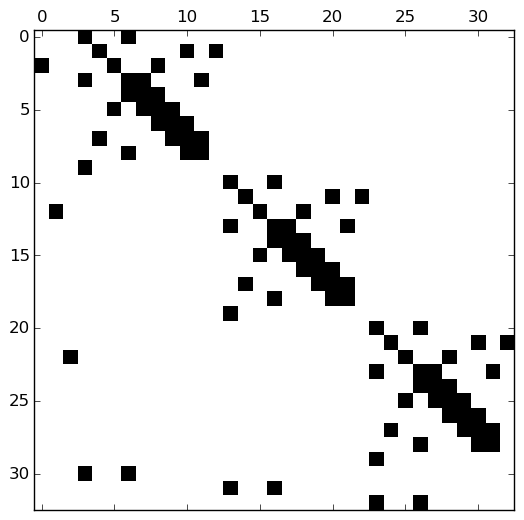

PyObject <matplotlib.image.AxesImage object at 0x7f68ef3b2e48>

In [17]:
spy(full([A1t; A2t][:,[idx1;idx2]]))

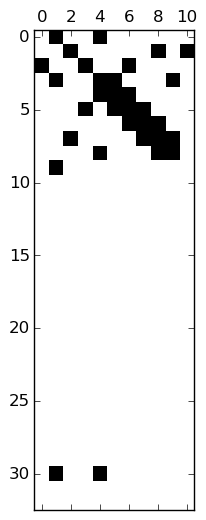

PyObject <matplotlib.image.AxesImage object at 0x7f68ef2e2a58>

In [20]:
spy(full(Acheck))

## using `eigs`

In [20]:
Q = sprand(100,100,0.5);

In [21]:
@time D,U = eig(full(Q));

  59.302 milliseconds (708 allocations: 952 KB)


In [18]:
@time D,U = eigs(Q,nev=Q.m);

 140.604 milliseconds (60707 allocations: 4427 KB)


In [19]:
D

98-element Array{Complex{Float64},1}:
   24.9548+0.0im     
  -3.18209+0.782786im
  -3.18209-0.782786im
   2.91424+1.4112im  
   2.91424-1.4112im  
   2.73449+1.3797im  
   2.73449-1.3797im  
   3.03556+0.0im     
  -1.56769+2.57496im 
  -1.56769-2.57496im 
  0.917652+2.808im   
  0.917652-2.808im   
  -1.94882+2.18884im 
          ⋮          
   1.06417-0.359675im
  0.900749+0.636742im
  0.900749-0.636742im
 -0.937261+0.529601im
 -0.937261-0.529601im
 -0.692985+0.807571im
 -0.692985-0.807571im
 -0.978486+0.358582im
 -0.978486-0.358582im
 -0.887171+0.0im     
  0.673188+0.109069im
  0.673188-0.109069im